In [2]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports & Data Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, classification_report
from sklearn.inspection import permutation_importance
import joblib

# 1. Load the Frozen Data (Relative path from 'notebooks' folder)
# Note: Adjust '../data/Splitted/' if your folder name differs slightly (e.g. 'processed')
TRAIN_X_PATH = "../data/Splitted/X_train.csv"
TRAIN_Y_PATH = "../data/Splitted/y_train.csv"
TEST_X_PATH =  "../data/Splitted/X_test.csv"
TEST_Y_PATH =  "../data/Splitted/y_test.csv"

X_train = pd.read_csv(TRAIN_X_PATH)
y_train = pd.read_csv(TRAIN_Y_PATH).values.ravel() # ravel() converts df to array
X_test = pd.read_csv(TEST_X_PATH)
y_test = pd.read_csv(TEST_Y_PATH).values.ravel()

print(f"Loaded Train Shape: {X_train.shape}")
print(f"Loaded Test Shape:  {X_test.shape}")

Loaded Train Shape: (4564, 96)
Loaded Test Shape:  (1141, 96)


### Sanity check 

Before tuning, we train a default Random Forest to verify everything works. This also gives you a "floor" for performance—if your tuned model performs worse than this, you over-engineered it.

In [4]:
# 2. Train Default Baseline
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

rf_baseline.fit(X_train, y_train)

# Quick check on Training set (just to see if it learned)
# DO NOT TOUCH TEST SET YET
train_prob = rf_baseline.predict_proba(X_train)[:, 1]
print(f"Baseline Train ROC-AUC: {roc_auc_score(y_train, train_prob):.4f}")
print("(If this is 1.0, you are overfitting heavily - normal for unpruned trees)")

Baseline Train ROC-AUC: 1.0000
(If this is 1.0, you are overfitting heavily - normal for unpruned trees)


### STEP 2: Hyperparameter Tuning & 5-fold CV

Your Tuning Grid:

n_estimators: 100, 200 (More is usually better but slower)

max_depth: 10, 20, None (Controls complexity)

min_samples_leaf: 2, 5, 10 (Controls overfitting - crucial for RF)

In [5]:
# 3. Setup Grid Search with Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_leaf': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample'] # Optional tweak
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc', # Optimizing for discrimination
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search... (Grab a coffee ☕)")
grid.fit(X_train, y_train)

print(f"\nBest Params: {grid.best_params_}")
print(f"Best CV ROC-AUC: {grid.best_score_:.4f}")

# The grid object automatically refits the best model on the full X_train
best_rf = grid.best_estimator_

Starting Grid Search... (Grab a coffee ☕)
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Best CV ROC-AUC: 0.6080


### Best Params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Best CV ROC-AUC: 0.6080

### Step 3: Final Evaluation 

In [6]:
from sklearn.calibration import calibration_curve

# 4. Predict on Test Set
# We need PROBABILITIES, not just labels (0/1)
y_prob_test = best_rf.predict_proba(X_test)[:, 1]

# 5. Calculate Mandatory Metrics
final_auc = roc_auc_score(y_test, y_prob_test)
final_prauc = average_precision_score(y_test, y_prob_test)
final_brier = brier_score_loss(y_test, y_prob_test)

print("--- FINAL TEST RESULTS (Teammate 2) ---")
print(f"ROC-AUC:   {final_auc:.4f}")
print(f"PR-AUC:    {final_prauc:.4f}")
print(f"Brier:     {final_brier:.4f}")



--- FINAL TEST RESULTS (Teammate 2) ---
ROC-AUC:   0.5974
PR-AUC:    0.5027
Brier:     0.2404


## ___ UNDER FITTING ___

### Round 2 AGGRESSIVE TUNING

In [7]:
# ROUND 2: AGGRESSIVE TUNING
# We focus on fighting UNDER-fitting (Low Bias / High Variance)

param_grid_aggressive = {
    # Let trees grow deeper
    'max_depth': [15, 25, None], 
    
    # Let trees see more variables at each split (capture weak signals)
    'max_features': ['sqrt', 0.5], 
    
    # Allow smaller leaves (capture fine-grained patterns)
    'min_samples_leaf': [1, 2, 4],
    
    # Increase trees to smooth out the extra noise we just invited
    'n_estimators': [300],
    
    # Sometimes 'balanced' hurts AUC by forcing focus on noisy outliers. 
    # We try both.
    'class_weight': ['balanced', None] 
}

grid_aggressive = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_aggressive,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting Aggressive Grid Search...")
grid_aggressive.fit(X_train, y_train)

print(f"\nNew Best Params: {grid_aggressive.best_params_}")
print(f"New Best CV ROC-AUC: {grid_aggressive.best_score_:.4f}")

Starting Aggressive Grid Search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

New Best Params: {'class_weight': None, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
New Best CV ROC-AUC: 0.6094


In [8]:
from sklearn.calibration import calibration_curve

# 4. Predict on Test Set
# We need PROBABILITIES, not just labels (0/1)
y_prob_test = best_rf.predict_proba(X_test)[:, 1]

# 5. Calculate Mandatory Metrics
final_auc = roc_auc_score(y_test, y_prob_test)
final_prauc = average_precision_score(y_test, y_prob_test)
final_brier = brier_score_loss(y_test, y_prob_test)

print("--- FINAL TEST RESULTS (Teammate 2) ---")
print(f"ROC-AUC:   {final_auc:.4f}")
print(f"PR-AUC:    {final_prauc:.4f}")
print(f"Brier:     {final_brier:.4f}")



--- FINAL TEST RESULTS (Teammate 2) ---
ROC-AUC:   0.5974
PR-AUC:    0.5027
Brier:     0.2404


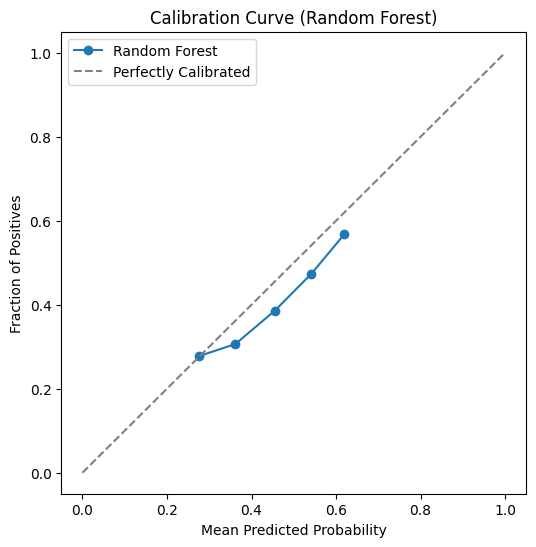

In [9]:
# 6. Plot Calibration Curve (Visual Requirement)
prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Random Forest)')
plt.legend()
plt.show()

### Feature Importance


--- Top 10 Features (Permutation Importance) ---
                     feature  importance_mean  importance_std
16                       bmi         0.013585        0.008016
0                        age         0.006573        0.004115
88  contraceptive_method_3.0         0.005171        0.003602
45        wall_material_21.0         0.003155        0.001888
90  contraceptive_method_6.0         0.001928        0.001227
77          toilet_type_12.0         0.001753        0.001838
44        wall_material_13.0         0.001578        0.002140
63         cooking_fuel_11.0         0.001315        0.001192
18          is_breastfeeding         0.000964        0.003707
67         water_source_21.0         0.000964        0.002613


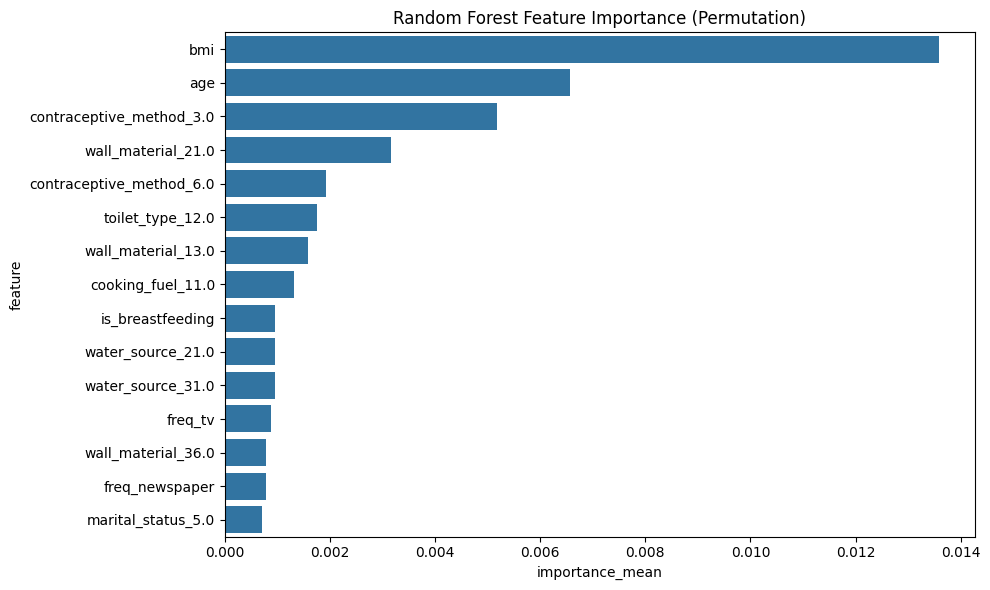

In [10]:
# 7. Permutation Importance
# This shuffles one column at a time to see how much the model breaks
result = permutation_importance(
    best_rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Organize into a DataFrame
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Show Top 10
print("\n--- Top 10 Features (Permutation Importance) ---")
print(importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance_mean', y='feature', data=importance_df.head(15))
plt.title("Random Forest Feature Importance (Permutation)")
plt.tight_layout()
plt.show()

### 8. Save Artifacts

In [14]:
# Save the model
joblib.dump(best_rf, "../results/rf_best_model.pkl")

# Save probabilities for Ensemble
results_df = pd.DataFrame({
    'y_true': y_test,
    'rf_prob': y_prob_test
})
results_df.to_csv("../results/teammate2_rf_predictions.csv", index=False)

print("✅ Model and predictions saved. Handoff ready.")

✅ Model and predictions saved. Handoff ready.
